In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [11]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    # Contruct Gram matrix and LHS
    txT = tx.T
    A = txT @ tx
    b = txT @ y
    
    return np.linalg.solve(A, b)

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [30]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    import sys
    sys.path.append("../../ex02/template")
    from gradient_descent import gradient_descent
    from grid_search import grid_search, generate_w, get_best_parameters
    
    ########################################################################################
    # Least squares
    ########################################################################################
    w_ls = least_squares(y, tx)
    
    ########################################################################################
    # Grid Search
    ########################################################################################
    # Generate the grid of parameters to be swept
    grid_w0, grid_w1 = generate_w(num_intervals=100)
    
    # Start the grid search
    grid_losses = grid_search(y, tx, grid_w0, grid_w1)

    # Select the best combinaison
    loss_grid, w0_grid, w1_grid = get_best_parameters(grid_w0, grid_w1, grid_losses)
    w_grid = [w0_grid, w1_grid]
    
    ########################################################################################
    # Gradient Descent
    ########################################################################################   
    # Define the parameters of the algorithm.
    max_iters = 50
    gamma = 0.5
    w_initial = np.array([-10, 10])
    
    # Run gradient descent
    loss_gd, ws_gd = gradient_descent(y, tx, w_initial, max_iters, gamma, verbose=False)
    w_gd = ws_gd[-1]
    
    ########################################################################################
    # Results
    ########################################################################################
    print(f'Least Squares:    {w_ls} | {np.linalg.norm(w_ls-w_ls)}')
    print(f'Grid Search:      {w_grid} | {np.linalg.norm(w_grid-w_ls)}')
    print(f'Gradient Descent: {w_gd} | {np.linalg.norm(w_gd-w_ls)}')

test_your_least_squares()

Least Squares:    [73.293922   13.47971243] | 0.0
Grid Search:      [72.72727272727272, 13.636363636363626] | 0.5879039033382045
Gradient Descent: [73.293922   13.47971243] | 1.1368683772161603e-13


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [33]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [35]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    if (degree < 0): raise ValueError("degree must be positive")
    
    phi = np.zeros((len(x), degree+1))
    
    phi[:,0] = 1
    for d in range(1,degree+1):
        phi[:,d] = phi[:,d-1] * x
    
    return phi

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

Processing 1th experiment, degree=1, rmse=0.4718760796342188
Processing 2th experiment, degree=3, rmse=0.25858277667737467
Processing 3th experiment, degree=7, rmse=0.24965870360907416
Processing 4th experiment, degree=12, rmse=0.24511133279075628


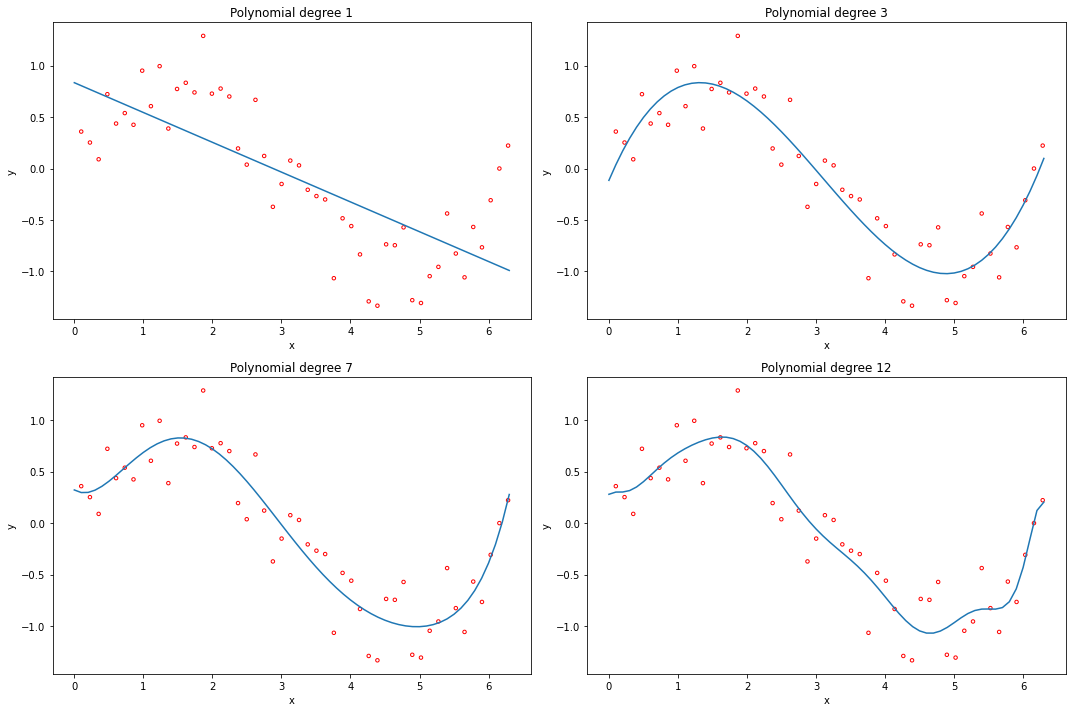

In [124]:
from plots import *

def compute_mse(y, tx, w):
    """Calculate the loss."""
    N = len(y)
    e = y - (tx @ w)
    L = (0.5 / N) * np.dot(e, e)
    return L

def compute_rmse(y, tx, w):
    return np.sqrt(2*compute_mse(y, tx, w))

def polynomial_regression(x, y):
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        # form the data to do polynomial regression.
        tx = build_poly(x, degree)
        
        # least square and calculate RMSE
        weights = least_squares(y, tx)
        rmse = compute_rmse(y, tx, weights)

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

plt.rcParams['figure.figsize'] = [15, 10]
polynomial_regression(x, y)

Yes, the fit (RMSE) gets better as the polynomial degree increases. This is to be expected, as a higher degree polynomial has more "degrees of freedom" to more closely follow the data.

Given the shape of the data, my preferred model would be that of degree 3. It seems to fit the data well, but isn't quite as noisy as the degree 12 polynomial. The degree 7 is also a good choice, but the upward trend at the end seems suspicious (the data seems to be trending down).

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [120]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    if (ratio < 0 or ratio > 1): raise ValueError("ratio must be in [0,1]")
    # set seed
    np.random.seed(seed)

    # split the data based on the given ratio
    mask = np.random.rand(len(x)) <= ratio
    
    ## Random permutation
    #idx = np.random.permutation(len(x))
    
    #train_x = x[idx[mask]]
    #train_y = y[idx[mask]]
    
    #mask = ~mask
    #test_x = x[idx[mask]]
    #test_y = y[idx[mask]]
    
    train_x = x[mask]
    train_y = y[mask]
    
    mask = ~mask
    test_x = x[mask]
    test_y = y[mask]
    
    return train_x, train_y, test_x, test_y

Then, test your `split_data` function below.

a)
No, the order of the samples should not be important.

Moreover, it seems that if the samples are permuted, there is a chance that all the chosen training data will be close together, so it's not a representative sample. This assumes that the data is already sorted.

In [141]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # split the data, and return train and test data
    x_tr, y_tr, x_te, y_te = split_data(x, y, ratio, seed)
    
    # form train and test data with polynomial basis function
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    
    # calculate weight through least square
    w = least_squares(y_tr, tx_tr)
    
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively
    rmse_tr = compute_rmse(y_tr, tx_tr, w)
    rmse_te = compute_rmse(y_te, tx_te, w)
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.5f}, Testing RMSE={te:.5f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))
    #print(f'{np.shape(tx_tr)}, {np.shape(tx_te)}')
    #print(f'{w}')
    
    return w, x_tr, y_tr, x_te, y_te

proportion=0.9, degree=1, Training RMSE=0.47841, Testing RMSE=0.42225
proportion=0.9, degree=3, Training RMSE=0.26298, Testing RMSE=0.23293
proportion=0.9, degree=7, Training RMSE=0.25310, Testing RMSE=0.22983
proportion=0.9, degree=12, Training RMSE=0.24783, Testing RMSE=0.21795


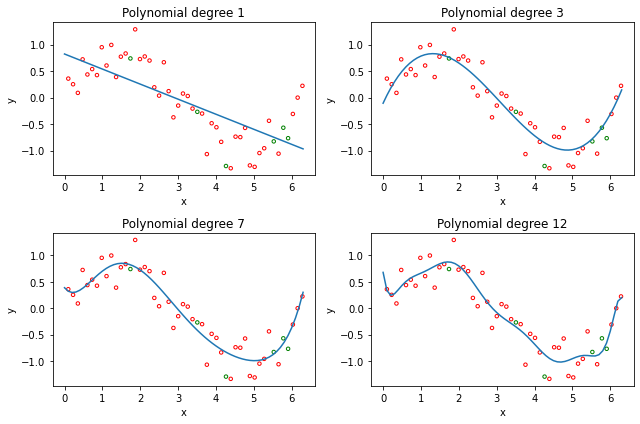

proportion=0.5, degree=1, Training RMSE=0.51840, Testing RMSE=0.53797
proportion=0.5, degree=3, Training RMSE=0.27698, Testing RMSE=0.24655
proportion=0.5, degree=7, Training RMSE=0.24841, Testing RMSE=0.30871
proportion=0.5, degree=12, Training RMSE=0.22978, Testing RMSE=0.32928


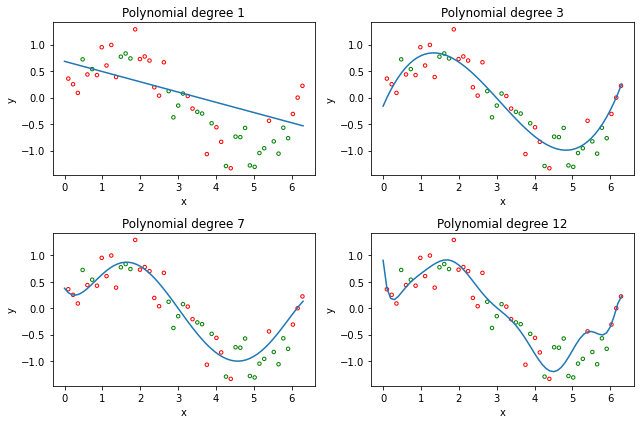

proportion=0.1, degree=1, Training RMSE=0.46405, Testing RMSE=0.75428
proportion=0.1, degree=3, Training RMSE=0.13848, Testing RMSE=0.42283
proportion=0.1, degree=7, Training RMSE=0.00000, Testing RMSE=6.98209
proportion=0.1, degree=12, Training RMSE=0.00000, Testing RMSE=824.30575


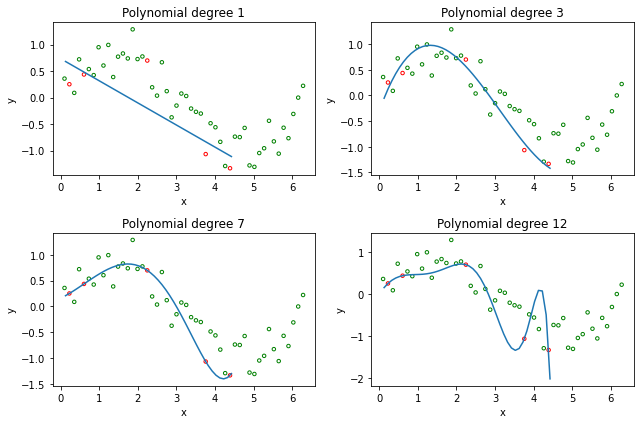

In [142]:
seed = 5
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

 # define the structure of the figure
num_row = 2
num_col = 2
plot = True
plt.rcParams['figure.figsize'] = [9, 6]

for split_ratio in split_ratios:
    if plot:
        f, axs = plt.subplots(num_row, num_col)
    for ind, degree in enumerate(degrees):
        w, x_tr, y_tr, x_te, y_te = train_test_split_demo(x, y, degree, split_ratio, seed)
        
        # plot fitted training data
        if plot:
            ax = axs[ind // num_col][ind % num_col]
            plot_fitted_curve(y_tr, x_tr, w, degree, ax)
            ax.scatter(x_te, y_te, color='b', s=12, facecolors='none', edgecolors='g')
    if plot:
        plt.tight_layout()
        plt.show()
    else:
        print('\n')

a)
The results for the training and testing RMSE for the degree 3 polynomial follow what we might expect.

- In the 90-10 split, there is enough data to train our model to fit the data well, to the point that the RMSE on the test data is smaller than the training RMSE. However, there might be too little testing data, so we can't be too confident our model performs well on novel data.
- In the 10-90 split, there is too little training data and our model likely overfits the data. Moreover, the testing RMSE is much higher than the training RMSE, which again suggests our model is overfit and does not predict new data well.
- The 50-50 split is a middle ground between these two. The testing RMSE is higher than the 90-10 split, which may be because there is more data to test against. 

------------------------------------------------------------------------------------------------------------------------------------------------

b)
The results for the other two degrees follow a similar pattern.

In particular, the 10-90 split leads to overfitting, which is suggested by the training RMSE of 0, and the much higher RMSE for the testing data. The overfitting is even worse than the degree 3 case, as with only 5 data points the higher order models fit the training data exactly. The overfitting is particularly bad in the degree 12 model, as shown by the huge testing RMSE.

------------------------------------------------------------------------------------------------------------------------------------------------

c)
Taken together, it seems like the 50-50 split is a good choice for the split, as it clearly shows that the simpler degree 3 model outperforms the more complex high-degree models on novel data.

The 50-50 split provides enough data to train our model, and enough testing data to give us confidence it performs well on new data.

------------------------------------------------------------------------------------------------------------------------------------------------

d)
I think part of the reason the degree 12 RMSE is so high has to do with the shape of odd/even functions. The data seems to be close to a degree 3 polynomial, and it has an "odd" shape: /\/. But a degree 12 polynomial has an "even" shape: /\/\. From the graphs, we can see that after fitting the 5 training points exactly, the degree 7 polynomial shoot up towards the testing data, but the degree 12 shoots down away from it.

So the degree 12 polynomial is very far away from the testing data.

The notes also suggest that the high RMSE is due to numerical errors. This makes sense, because the degree 12 model shoots down, so its error relative to the testing data is very large. Numerically, large numbers tend to "absorb" small numbers when they're added together (i.e. round-off error is large for large numbers). So the error terms are dominated by the large values of X.T @ w. 


------------------------------------------------------------------------------------------------------------------------------------------------

e)
I suspect that if we had 5000 samples instead of 50, the 90-10 split and even the 10-90 would work well. There is so much data that we are unlikely to be overfitting, and the additional testing data can give us a higher confidence that our model is well trained.


# 3 Ridge Regression
Please fill in the function below.

In [143]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    # Contruct coefficient matrix and LHS
    N = len(y)
    txT = tx.T
    A = txT @ tx
    np.fill_diagonal(A, A.diagonal() + 2*N*lambda_) # add lambda*I
    b = txT @ y
    
    return np.linalg.solve(A, b)

In [144]:
from helpers import *
def test_your_ridge_regression(lambda_):
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    # Ridge regression
    w_rr = ridge_regression(y, tx, lambda_)
    rmse_rr = compute_rmse(y, tx, w_rr)
    
    # Least Squares
    w_ls = least_squares(y, tx)
    rmse_ls = compute_rmse(y, tx, w_ls)
    
    # Results
    print(f'Ridge Regression\n\tW: {w_rr} | {np.linalg.norm(w_rr-w_rr)}\n\tRMSE: {rmse_rr:.3e}')
    print(f'Least Squares\n\tW: {w_ls} | {np.linalg.norm(w_rr-w_ls)}\n\tRMSE: {rmse_ls:.3e}')
    print('')

lambdas = [0, 1.0E5]
for lambda_ in lambdas:
    print(f'LAMBDA = {lambda_:,.0f}')
    test_your_ridge_regression(lambda_)

LAMBDA = 0
Ridge Regression
	W: [73.293922   13.47971243] | 0.0
	RMSE: 5.547e+00
Least Squares
	W: [73.293922   13.47971243] | 0.0
	RMSE: 5.547e+00

LAMBDA = 100,000
Ridge Regression
	W: [3.66467778e-04 6.73982252e-05] | 0.0
	RMSE: 7.473e+01
Least Squares
	W: [73.293922   13.47971243] | 74.52278922034996
	RMSE: 5.547e+00



In [191]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    
    # split the data, and return train and test data
    x_tr, y_tr, x_te, y_te = split_data(x, y, ratio, seed)
    
    # form train and test data with polynomial basis function
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ridge regression with a given lambda
        w = ridge_regression(y_tr, tx_tr, lambda_)
    
        # calculate RMSE for train and test data
        rmse_tr.append(compute_rmse(y_tr, tx_tr, w))
        rmse_te.append(compute_rmse(y_te, tx_te, w))
        
        print("proportion={p}, degree={d}, lambda={l:.3e}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}, |w|={w2:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind], w2=np.linalg.norm(w)))
        #print(f"shape_tr={np.shape(tx_tr)}, shape_te={np.shape(tx_te)}")
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)


proportion=0.5, degree=7, lambda=1.000e-05, Training RMSE=0.167, Testing RMSE=0.381, |w|=1.282
proportion=0.5, degree=7, lambda=2.276e-05, Training RMSE=0.167, Testing RMSE=0.383, |w|=1.019
proportion=0.5, degree=7, lambda=5.179e-05, Training RMSE=0.167, Testing RMSE=0.385, |w|=0.789
proportion=0.5, degree=7, lambda=1.179e-04, Training RMSE=0.168, Testing RMSE=0.387, |w|=0.658
proportion=0.5, degree=7, lambda=2.683e-04, Training RMSE=0.168, Testing RMSE=0.388, |w|=0.597
proportion=0.5, degree=7, lambda=6.105e-04, Training RMSE=0.168, Testing RMSE=0.390, |w|=0.556
proportion=0.5, degree=7, lambda=1.389e-03, Training RMSE=0.168, Testing RMSE=0.391, |w|=0.519
proportion=0.5, degree=7, lambda=3.162e-03, Training RMSE=0.168, Testing RMSE=0.392, |w|=0.490
proportion=0.5, degree=7, lambda=7.197e-03, Training RMSE=0.169, Testing RMSE=0.390, |w|=0.467
proportion=0.5, degree=7, lambda=1.638e-02, Training RMSE=0.171, Testing RMSE=0.386, |w|=0.436
proportion=0.5, degree=7, lambda=3.728e-02, Traini

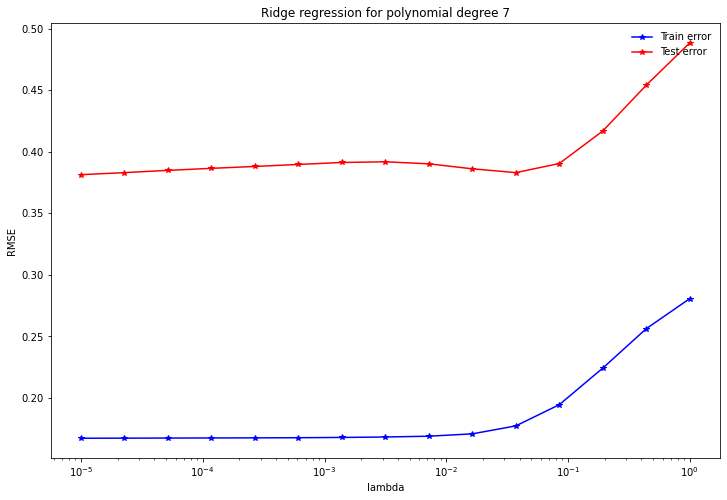

In [192]:
plt.rcParams['figure.figsize'] = [12, 8]
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)